# Data set 3<br>
The original source of this dataset contained monthly measurements of global land temperatures by country, reported between 1743 and 2013. The measurements were aggregated by the average and variability of temperature measurements within each country each month. Due to a high rate of missing values in previous years, the data used for our experiments started in 1900. The Primary Source dataset included data from 1900 to 1999, and the measurements from this century constituted the block of new records. <br>
## Preliminaries

Import and load the uses Python packages and modules:

In [1]:
import sys
import os
# Add the parent directory to sys.path
parent_directory = os.path.abspath(os.path.join(os.getcwd(), '../main/'))
sys.path.insert(0, parent_directory)
import pandas as pd
import numpy as np
import sim_experiments as smexp_dyn
from datetime import date
import autoversion_service as av
import autoversion_aemod as avae

Load the data set and prepare it:

In [2]:
data= pd.read_csv("../datasets/ds03-GlobalLandTemperaturesByCountry.csv")
df = data.pivot(columns="Country", values=["AverageTemperature", "AverageTemperatureUncertainty"], index="dt")
df_1900 = df.loc[(df.index>="1900-01-01") & (df.index<="1999-31-12"),:]
df_2000 = df.loc[df.index > "1999-31-12",:]

Exploratory analysis showing time series decomposigion as an additive model where each time instant ($x_i$) is the addition of a trend component ($T_i$), a seasonal component ($S_i$) and an error component ($E_i$). There are high percentages of missing values in this dataset, so linear interpolation is performed prior to the exploratory analysis of the time series components

In [3]:
redmid_ds = pd.concat([df_1900.iloc[-500:,:], df_2000]).interpolate(method="linear")
red_ds = pd.concat([df_1900, df_2000]).interpolate(method="linear")
smexp_dyn.plot_time_components_div(red_ds, df_1900.index, df_2000.index, 12, xplot_ps=df_1900.index, xplot_rev=df_2000.index, dsname="ds03comb",
                                   xtxtsize=5, path_figs="../figures/")

'done'

## Primary Source models<br>
Obtain the parameters for the reference batch of data. The function returns a dictionary *ps_dict* with the parameters to compute each one of the drift metrics according to a different ML model and the _indPS_ variable with the indices of the records used for the reference set.

Doing Primary Source Model -- 

Step [1/6]: Printing the Original Data Set Features =======
Step [1/6]: Starting ...
        AverageTemperature                                         \
Country        Afghanistan       Africa      Albania      Algeria   
count          1200.000000  1200.000000  1200.000000  1200.000000   
mean             14.064982    24.148269    12.784281    23.126078   
std               9.197608     1.713240     6.827289     7.689757   
min              -4.379000    19.794000    -2.049000     9.591000   
25%               5.617000    22.848000     6.735500    16.390750   
50%              14.174500    24.938000    12.467000    23.284500   
75%              22.893500    25.471250    19.214000    30.550000   
max              28.533000    26.905000    25.153000    35.178000   

                                                                          \
Country American Samoa      Andorra       Angola     Anguilla Antarctica   
count      1200.000000  1200.000000  120

2023-11-24 18:38:58.349794: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "my_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 374)               181764    
                                                                 
 sequential_1 (Sequential)   (None, 485)               181875    
                                                                 
Total params: 363,639
Trainable params: 363,639
Non-trainable params: 0
_________________________________________________________________
Best model - DONE
6/6 [==============================] - 0s 4ms/step
Data model -  DONE
Permutation test -  DONE
dE-AE summary: 285.4603261947632 s.; 640 b.
Step [3/6]: Finished.


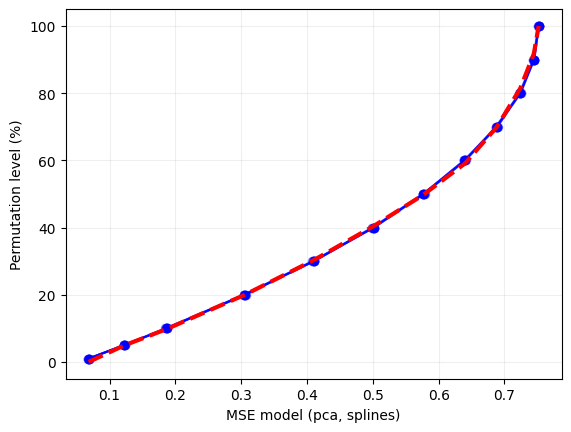

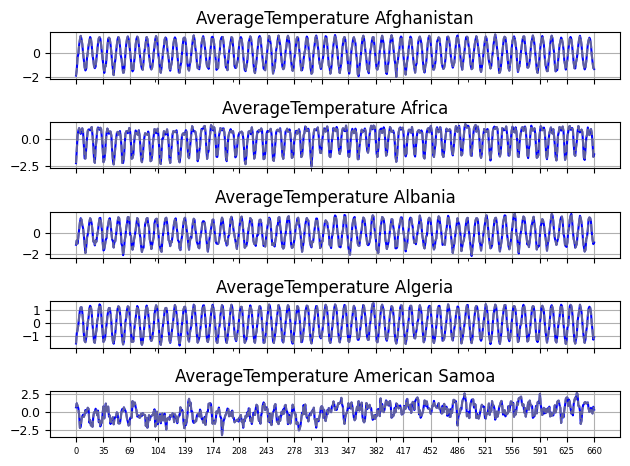

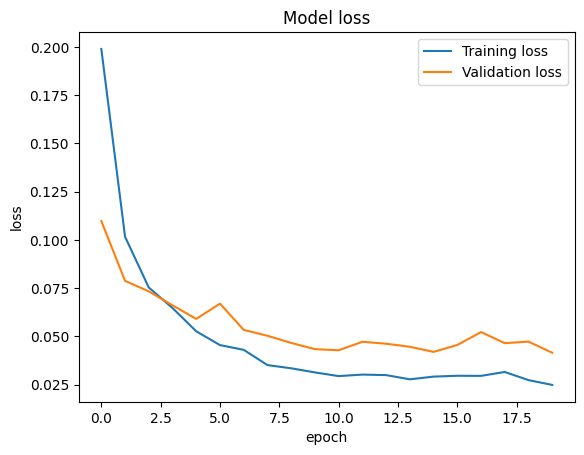

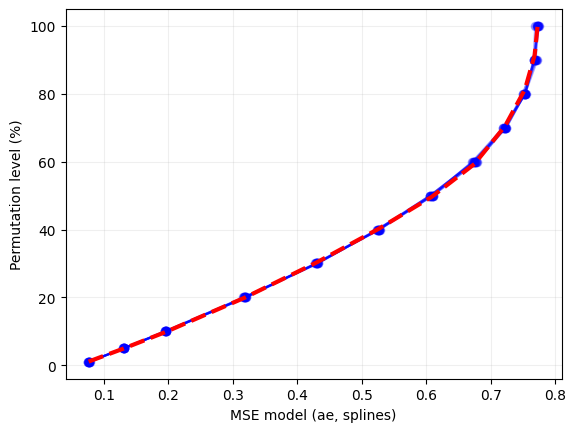

In [4]:
# %%
import random
import tensorflow as tf
tf.random.set_seed(42) 
np.random.seed(42)
random.seed(42)
print("Doing Primary Source Model -- \n")
ps_dict, ind_PS = smexp_dyn.get_PS_data(df_1900, resultspath = "../results/ds03-demo/",  dstitle = "DS 03 PS", PSfilename = "ds03ps.pkl", pctge_PS=1,
                                        mse_model_type="splines", tr_val_split=0.69, resultsfile =  "/dyn-ds-03")

In [5]:
X_PS = df_1900.loc[list(ind_PS),:].copy()
X_NEW = df_2000
print("Primary Source N = " + str(len(X_PS)) + " (" + str(np.round(len(X_PS)/(len(X_PS) + len(X_NEW))*100,2)) + " %" + " of total dataset length)")

Primary Source N = 1200 (87.91 % of total dataset length)


### New versions<br>
When a new version of the dataset is generated, it will be compared to the information from the previous version in the following way:<br>
  * $d_{P}$: computes the cosine distance between loading matrices obtained for both data sets;<br>
  * $d_{E, PCA}$: computes the MSE obtained by reconstructing the new batch using the reference PCA model. This value is fed into a quadratic model fitted with the reference data set, which relates MSE values to levels of corruption artificially simulated by permuting entries from the reference set.<br>
  * $d_{E, AE}$: computes the MSE obtained by reconstructing the new batch using the reference AE model. This value is fed into a quadratic model fitted with the reference data set, which relates MSE values to levels of corruption artificially simulated by permuting entries from the reference set.<br>


## Creation events<br>
The following experiments use an initial subset as reference and add new batches of different size.

In [6]:
print("  - Case 1: add rows of new set \n")
# Add batches of 10% New Dataset records' size
ds03_c_demo = smexp_dyn.do_exp(X_NEW, ps_dict, resultspath = "../results/ds03-demo", mod_pca = True, mod_ae = True, 
                    mode_der = "add_batch", batchsize_pctges = [0.1], demo = True,
                  dstitle="DS 03 creation-demo", kfolds=0, resultsfile="/demo-ds03-creation")

__, vC_pca_dp = av.versionDER(ds03_c_demo, ps_dict["PS_dic"]["PCA"]["S"], outdict=True,  loadfile=False, dstitle="DS 03 creation-demo pca-dP", cat_threshold=2)
__, vC_pca_de = av.versionDER(ds03_c_demo, ps_dict["PS_dic"]["PCA"]["E"], outdict=True,  loadfile=False, dstitle="DS 03 creation-demo pca-dE", drift_dist="dE", 
                                  cat_threshold = 2)
vC_ae_de = avae.versionDER(ds03_c_demo, ps_dict["PS_dic"]["AE"], "../results/ds03-demo/aelogs/tb_logs", "../results/ds03", outdict=True, loadfile=False,  
                               dstitle="DS 03 creation-demo ae", cat_threshold = 2)

print("DS 03 - PS - v.tag: " + ps_dict["PS_dic"]["PCA"]["S"]["vtag"])
print("DS 03 - demo creation - PCA dP v.tag: " + vC_pca_dp["vtag"])
print("DS 03 - demo creation - PCA dE v.tag: " + vC_pca_de["vtag"])
print("DS 03 - demo creation - AE v.tag: " + vC_ae_de["vtag"])

  - Case 1: add rows of new set 

New versions, level 0.1- start
DS 03 - PS - v.tag: 1.0.<11/24/2023 - 17:37:48>
DS 03 - demo creation - PCA dP v.tag: 1.57.<11/24/2023 - 17:43:44>
DS 03 - demo creation - PCA dE v.tag: 1.1.<11/24/2023 - 17:43:44>
DS 03 - demo creation - AE v.tag: 1.2.<11/24/2023 - 17:43:44>


## Update events<br>

In [7]:
print("  - Case 2: transform columns ..\n")

ds03_u_demo = smexp_dyn.do_exp(X_PS, ps_dict, resultspath = "../results/ds03-demo",  mode_der = "trans_cols",
                    tr_pctges = [0.5], dstitle="DS 03 update-demo", batchsize_pctges=[1], kfolds=1,
                    modetr="cbrt",resultsfile="/demo-ds03-trcols-cbrt", demo = True)

__, vU_pca_dp = av.versionDER(ds03_u_demo, ps_dict["PS_dic"]["PCA"]["S"], outdict=True,  loadfile=False, dstitle="DS 03 update-demo pca-dP", cat_threshold=2)
__, vU_pca_de = av.versionDER(ds03_u_demo, ps_dict["PS_dic"]["PCA"]["E"], outdict=True,  loadfile=False, dstitle="DS 03 update-demo pca-dE", drift_dist="dE", 
                                  cat_threshold = 2)
vU_ae_de = avae.versionDER(ds03_u_demo, ps_dict["PS_dic"]["AE"], "../results/ds03-demo/aelogs/tb_logs", "../results/ds03", outdict=True, loadfile=False,  
                               dstitle="DS 03 update-demo ae", cat_threshold = 2)

print("DS 03 - PS - v.tag: " + ps_dict["PS_dic"]["PCA"]["S"]["vtag"])
print("DS 03 - demo update - PCA dP v.tag: " + vU_pca_dp["vtag"])
print("DS 03 - demo update - PCA dE v.tag: " + vU_pca_de["vtag"])
print("DS 03 - demo update - AE v.tag: " + vU_ae_de["vtag"])

  - Case 2: transform columns ..

New versions, level [0.5]- start
DS 03 - PS - v.tag: 1.0.<11/24/2023 - 17:37:48>
DS 03 - demo update - PCA dP v.tag: 1.25.<11/24/2023 - 17:44:57>
DS 03 - demo update - PCA dE v.tag: 1.100.<11/24/2023 - 17:44:58>
DS 03 - demo update - AE v.tag: 1.100.<11/24/2023 - 17:44:58>


## Deletion events<br>
In the following cases, the reference set contains all the records and some of them are deleted in different ways: signals are down sampled, outliers are removed, etc.

In [8]:
print("  - Case 3: remove rows decimate .. \n")
ds03_d_demo = smexp_dyn.do_exp(X_PS, ps_dict, resultspath = "../results/ds03-demo",  mode_der = "rem_rows_decimate",
                    tr_pctges = [0.5], dstitle="DS 03 deletion-demo", batchsize_pctges=[1], resultsfile="/demo-ds03-deletion", 
                    demo = True)

__, vD_pca_dp = av.versionDER(ds03_d_demo, ps_dict["PS_dic"]["PCA"]["S"], outdict=True,  loadfile=False, dstitle="DS 03 deletion-demo pca-dP", cat_threshold=2)
__, vD_pca_de = av.versionDER(ds03_d_demo, ps_dict["PS_dic"]["PCA"]["E"], outdict=True,  loadfile=False, dstitle="DS 03 deletion-demo pca-dE", drift_dist="dE", 
                                  cat_threshold = 2)
vD_ae_de = avae.versionDER(ds03_d_demo, ps_dict["PS_dic"]["AE"], "../results/ds03-demo/aelogs/tb_logs", "../results/ds03", outdict=True, loadfile=False,  
                               dstitle="DS 03 deletion-demo ae", cat_threshold = 2)

print("DS 03 - PS - v.tag: " + ps_dict["PS_dic"]["PCA"]["S"]["vtag"])
print("DS 03 - demo deletion - PCA dP v.tag: " + vD_pca_dp["vtag"])
print("DS 03 - demo deletion - PCA dE v.tag: " + vD_pca_de["vtag"])
print("DS 03 - demo deletion - AE v.tag: " + vD_ae_de["vtag"])

  - Case 3: remove rows decimate .. 

New versions, level [0.5]- start
DS 03 - PS - v.tag: 1.0.<11/24/2023 - 17:37:48>
DS 03 - demo deletion - PCA dP v.tag: 1.27.<11/24/2023 - 17:45:55>
DS 03 - demo deletion - PCA dE v.tag: 1.0.<11/24/2023 - 17:45:56>
DS 03 - demo deletion - AE v.tag: 1.0.<11/24/2023 - 17:45:56>


In [9]:
demo_results = pd.DataFrame({"datasets": "ds03", 
                "PS": {"dPCA_P": ps_dict["PS_dic"]["PCA"]["S"]["vtag"], "dPCA_E":  ps_dict["PS_dic"]["PCA"]["E"]["vtag"], 
                       "dAE_E": ps_dict["PS_dic"]["AE"]["vtag"]},
                "creation": {"dPCA_P": vC_pca_dp["vtag"], "dPCA_E": vC_pca_de["vtag"], "dAE_E": vC_ae_de["vtag"]},
                "update": {"dPCA_P": vU_pca_dp["vtag"], "dPCA_E": vU_pca_de["vtag"], "dAE_E": vU_ae_de["vtag"]}, 
                "deletion": {"dPCA_P": vD_pca_dp["vtag"], "dPCA_E": vD_pca_de["vtag"], "dAE_E": vD_ae_de["vtag"]}})
if os.path.exists("../results/demos.xlsx"):
       with pd.ExcelWriter("../results/demos.xlsx", engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
              demo_results.to_excel(writer, sheet_name="ds03")
else:
       demo_results.to_excel("../results/demos.xlsx", sheet_name='ds03')  
